In [15]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [16]:
main_dir='/cloud/skogsstyrelsen_1c_attempt_2/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [17]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
model_load_paths=['cot_model_new_surf/0/model_it_2000000','cot_model_new_surf/1/model_it_2000000',
                  'cot_model_new_surf/2/model_it_2000000','cot_model_new_surf/3/model_it_2000000',
                  'cot_model_new_surf/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

means=[0.538923,0.530993,0.579427,0.630218,0.759563,0.807696,0.767415,0.839607,0.402664,0.066681,0.442786,0.344600,58.065838]
stds=[0.199267,0.175733,0.179156,0.165408,0.157317,0.157984,0.151002,0.158407,0.232892,0.096684,0.313212,0.220723,15.569941]


In [19]:
main_filepath='pytorch_models/COT_dumb_anton_trans'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
index_median=1

In [20]:
models[0]

In [21]:
pairs_all=[]
pairs_all_ix=[]
ims_all=[]
cots_all=[]
temporals_all=[]
divide=10000
for i,dir in enumerate(directories):
    print('dir '+str(i)+' of '+str(len(directories)))
    pairs=[]
    pairs_ix=[]
    #Get temporals for directory
    temporals_t=glob.glob(main_dir+dir+'/*.nc')
    temporals=[]
    for t in temporals_t:
        temporals.append(t.split('/')[-1].split('.')[0])
    temporals_all.append(temporals)
    ims=[]
    cots=[]
    for j,temp in enumerate(temporals):
        print('     Temporal '+str(j)+' of '+str(len(temporals)))

        loaded_data = xr.open_dataset(main_dir+dir+'/'+temp+'.nc', engine='netcdf4', decode_times=True)
        nodata = loaded_data.attrs.get("nodata", None)
        loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
        variables=loaded_data.variables

        if int(temp.split('-')[0])>=2022: #Add offset to all data past 2022
            offset=-1000
        else:
            offset=0
        ## Get bands ##
        b02=(np.clip(variables['b02'].data[0,:,:],offset,10000)+offset)/divide
        b03=(np.clip(variables['b03'].data[0,:,:],offset,10000)+offset)/divide
        b04=(np.clip(variables['b04'].data[0,:,:],offset,10000)+offset)/divide
        b05=(np.clip(variables['b05'].data[0,:,:],offset,10000)+offset)/divide
        b06=(np.clip(variables['b06'].data[0,:,:],offset,10000)+offset)/divide
        b07=(np.clip(variables['b07'].data[0,:,:],offset,10000)+offset)/divide
        b08=(np.clip(variables['b08'].data[0,:,:],offset,10000)+offset)/divide
        b8a=(np.clip(variables['b8a'].data[0,:,:],offset,10000)+offset)/divide
        b09=(np.clip(variables['b09'].data[0,:,:],offset,10000)+offset)/divide
        b10=(np.clip(variables['b10'].data[0,:,:],offset,10000)+offset)/divide
        b11=(np.clip(variables['b11'].data[0,:,:],offset,10000)+offset)/divide
        b12=(np.clip(variables['b12'].data[0,:,:],offset,10000)+offset)/divide
        sun_z=variables['sun_zenith']

        ## Save image ##
        im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
        im[:,:,0]=b02
        im[:,:,1]=b03
        im[:,:,2]=b04
        im[:,:,3]=b05
        im[:,:,4]=b06
        im[:,:,5]=b07
        im[:,:,6]=b08
        im[:,:,7]=b8a
        im[:,:,8]=b09
        im[:,:,9]=b10
        im[:,:,10]=b11
        im[:,:,11]=b12
        im[:,:,12]=sun_z


        #Reshape and prepare COT estimation
        im_shape=np.shape(im)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r - means) / stds
        image_input_tens=torch.tensor(inputs,dtype=torch.float,device=device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.019*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2

        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])
        cots.append(im_pred_cot_t_r)
        im_wcot=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
        im_wcot[:,:,0:13]=im
        im_wcot[:,:,13]=im_pred_cot_t
        ims.append(im_wcot)
    
    cloud_cov=0.05
    for j,cot in enumerate(cots):
        frac_cloud=np.sum(cot>0)/np.size(cot)
        if frac_cloud>=cloud_cov: #If more than 5 % clouds
            if j<(len(cots)-1):
                if np.sum(cots[j+1]>1)/np.size(cots[j+1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j+1],temporals[j])
                    pair_ix=(j+1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
            elif j>0:
                if np.sum(cots[j-1]>0)/np.size(cots[j-1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j-1],temporals[j])
                    pair_ix=(j-1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
    pairs_all.append(pairs)
    pairs_all_ix.append(pairs_ix)
    ims_all.append(ims)

dir 0 of 22
     Temporal 0 of 13
     Temporal 1 of 13
     Temporal 2 of 13
     Temporal 3 of 13
     Temporal 4 of 13
     Temporal 5 of 13
     Temporal 6 of 13
     Temporal 7 of 13
     Temporal 8 of 13
     Temporal 9 of 13
     Temporal 10 of 13


     Temporal 11 of 13
     Temporal 12 of 13
dir 1 of 22
     Temporal 0 of 20
     Temporal 1 of 20
     Temporal 2 of 20
     Temporal 3 of 20
     Temporal 4 of 20
     Temporal 5 of 20
     Temporal 6 of 20
     Temporal 7 of 20
     Temporal 8 of 20
     Temporal 9 of 20
     Temporal 10 of 20
     Temporal 11 of 20
     Temporal 12 of 20
     Temporal 13 of 20
     Temporal 14 of 20
     Temporal 15 of 20
     Temporal 16 of 20
     Temporal 17 of 20
     Temporal 18 of 20
     Temporal 19 of 20
dir 2 of 22
     Temporal 0 of 18
     Temporal 1 of 18
     Temporal 2 of 18
     Temporal 3 of 18
     Temporal 4 of 18
     Temporal 5 of 18
     Temporal 6 of 18
     Temporal 7 of 18
     Temporal 8 of 18
     Temporal 9 of 18
     Temporal 10 of 18
     Temporal 11 of 18
     Temporal 12 of 18
     Temporal 13 of 18
     Temporal 14 of 18
     Temporal 15 of 18
     Temporal 16 of 18
     Temporal 17 of 18
dir 3 of 22
     Temporal 0 of 16
     Temporal 1 of 16
     Temporal 2 of 1

In [22]:
for i,pairs in enumerate(pairs_all):
    for j,pair in enumerate(pairs):
        print(pair)
        print(pairs_all_ix[i][j])
        

('2023-06-07', '2023-05-26')
(6, 5)
('2023-07-10', '2023-07-02')
(11, 10)
('2023-09-13', '2023-09-08')
(19, 18)
('2023-05-21', '2023-05-13')
(7, 6)
('2023-08-29', '2023-07-23')
(13, 12)
('2020-08-16', '2020-08-02')
(9, 8)
('2022-06-25', '2022-06-22')
(30, 29)
('2022-09-08', '2022-09-03')
(39, 38)
('2022-09-21', '2022-09-19')
(5, 4)
('2022-10-23', '2022-10-04')
(7, 6)
('2023-05-22', '2022-10-23')
(8, 7)
('2023-04-17', '2023-04-12')
(6, 5)
('2023-05-27', '2023-05-22')
(15, 14)
('2023-06-03', '2023-06-01')
(17, 16)
('2023-05-06', '2023-04-26')
(13, 12)
('2023-06-07', '2023-06-02')
(16, 15)
('2023-08-16', '2023-08-01')
(25, 24)
('2023-05-07', '2023-05-06')
(4, 3)
('2023-04-16', '2023-04-11')
(5, 4)
('2023-05-19', '2023-05-11')
(10, 9)
('2023-09-06', '2023-08-22')
(17, 16)
('2023-06-11', '2023-05-29')
(8, 7)
('2023-04-16', '2023-04-03')
(9, 8)
('2023-04-21', '2023-04-18')
(11, 10)
('2023-05-11', '2023-05-06')
(13, 12)
('2023-06-07', '2023-05-31')
(15, 14)
('2018-08-27', '2018-08-25')
(15, 1

In [23]:
pairs_count=0
for pairs in pairs_all:
    for pair in pairs:
        pairs_count+=1

In [24]:
pairs_count

43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


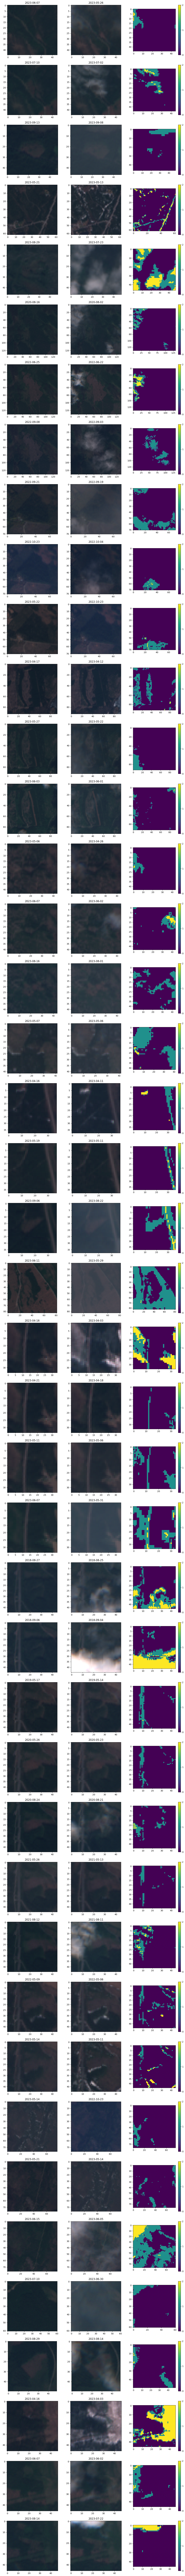

In [25]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]

    for j,pair in enumerate(pairs):


        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [26]:
#remove_pairs=np.array([0,1,4,10,12,13])
remove_pairs=np.array([3,11,13,14,17,18,19,20,22,23,24,25,28,29,31,33,34,35,36,38,40])
#remove_pairs=np.array([1,5,8,9,11,13,14,15,18,20,22,24,25])

In [27]:
pairs_all_new=[]
pairs_all_ix_new=[]
#Fix Tomorrow
p_c=0
for i,pairs in enumerate(pairs_all):
    pairs_tmp=[]
    pairs_ix_tmp=[]
    for j,pair in enumerate(pairs):

        if np.sum(remove_pairs==p_c)==0:
            pairs_tmp.append(pair)
            pairs_ix_tmp.append(pairs_all_ix[i][j])

        p_c+=1
    
    pairs_all_new.append(pairs_tmp)
    pairs_all_ix_new.append(pairs_ix_tmp)


In [28]:
pairs_count=0
for pairs in pairs_all_new:
    for pair in pairs:
        pairs_count+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


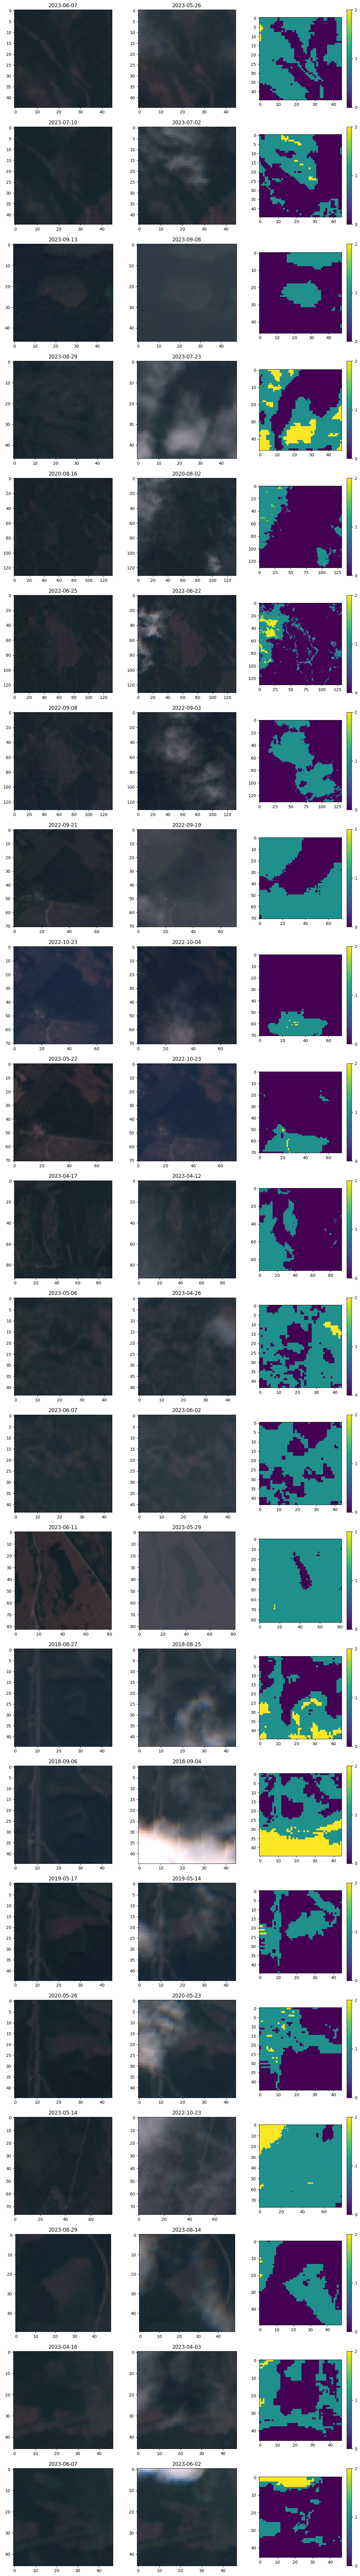

In [29]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix_new[i]

    for j,pair in enumerate(pairs):


        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        #New COT
                #Reshape and prepare COT estimation
        im_shape=np.shape(im_cloud)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for k in range(im_shape[2]):
            im_cloud_r[:,k]=np.reshape(im_cloud[:,:,k],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r[:,0:13] - means) / stds
        image_input_tens=torch.Tensor(inputs).to(device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.015*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2
        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])

        #Set new COT in im_cloud
        im_cloud[:,:,-1]=im_pred_cot_t
        ims[pairs[j][1]]=im_cloud

        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [30]:
pairs_all_=pairs_all_new
pairs_all_ix=pairs_all_ix_new

In [31]:
# Make predictions
ims_preds_all=[]
ims_unc_all=[]
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=[]
    ims_unc=[]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        ## Reshape cloudy data
        im_shape=np.shape(im_cloud)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_cot_t_r=im_cloud_r[:,-1]
        #One hot encode cot
        cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
        cot_one_hot[im_pred_cot_t_r==0,0]=1
        cot_one_hot[im_pred_cot_t_r==1,1]=1
        cot_one_hot[im_pred_cot_t_r==2,2]=1

        ## append cot estimation to input data ##
        im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+2))
        im_cloud_r_c[:,0:13]=im_cloud_r[:,0:13]
        im_cloud_r_c[:,13:16]=cot_one_hot

        ## Make prediction
        for i,model in enumerate(models):
            if i==0:
                pred=model.predict(im_cloud_r_c)
            else:   
                pred=pred+model.predict(im_cloud_r_c)
        pred=pred/len(models)

        ##Reshape back
        im_shape_pred=(im_shape[0],im_shape[1],12)
        im_pred=np.zeros(im_shape_pred)
        im_unc=np.zeros(im_shape_pred)
        for i in range(im_shape_pred[2]):
            im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
            im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])
        ims_preds.append(im_pred)
        ims_unc.append(im_unc)

    ims_preds_all.append(ims_preds)
    ims_unc_all.append(ims_unc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


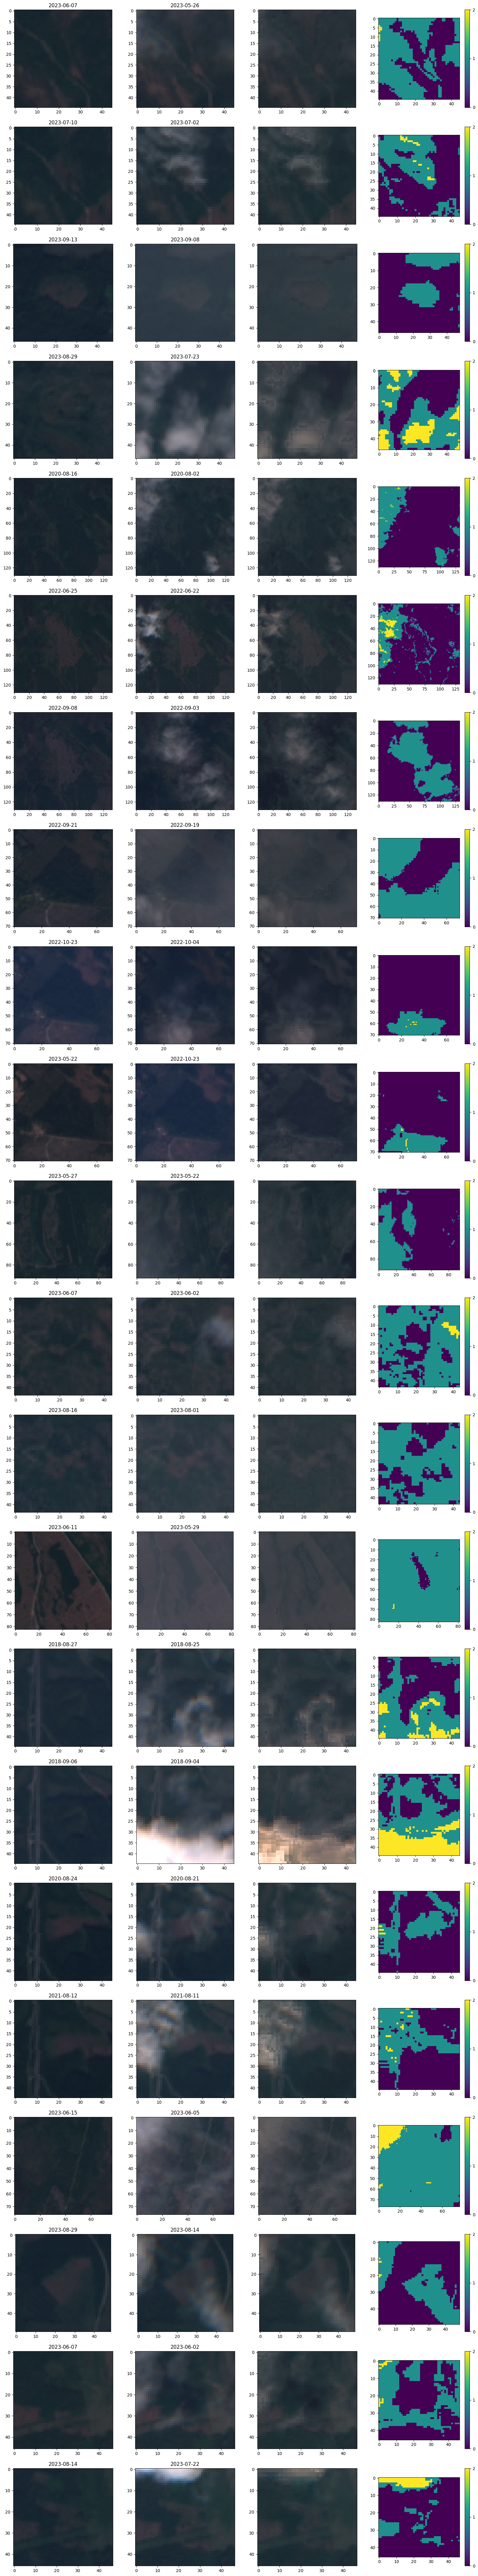

In [32]:
ncols=4
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=preds[j]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        axs[pair_c,2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

        im_c=axs[pair_c,3].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,3],ticks=[0,1,2])
        pair_c+=1

## Evaluate predictions

### NMSE

In [81]:
NMSEs_og=np.zeros((pairs_count,12))
NMSEs_pred=np.zeros((pairs_count,12))

p_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
        norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
        norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
        norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

        NMSE_og=norm_og/norm_gt
        NMSE_pred=norm_pred/norm_gt

        NMSEs_og[p_c,:]=NMSE_og
        NMSEs_pred[p_c,:]=NMSE_pred
        p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

In [82]:
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))    

NMSE before correction, Band 2: 2.305161168976403
NMSE after correction, Band 2: 0.1553797761769424
 
NMSE before correction, Band 3: 6.4023670272455515
NMSE after correction, Band 3: 0.8985747233170737
 
NMSE before correction, Band 4: 34.756426329439165
NMSE after correction, Band 4: 7.6431744384274936
 
NMSE before correction, Band 5: 9.274040971995303
NMSE after correction, Band 5: 2.61554655503544
 
NMSE before correction, Band 6: 0.49266081014717505
NMSE after correction, Band 6: 0.226555845506857
 
NMSE before correction, Band 7: 0.26749905046269823
NMSE after correction, Band 7: 0.13959476076169414
 
NMSE before correction, Band 8: 0.21176322362223646
NMSE after correction, Band 8: 0.1331286867499365
 
NMSE before correction, Band 8A: 0.19049108048186822
NMSE after correction, Band 8A: 0.1004918715030842
 
NMSE before correction, Band 9: 4.577976280854691
NMSE after correction, Band 9: 1.5665240755416996
 
NMSE before correction, Band 10: 33.61172229187585
NMSE after correction

### Percent from ground truth

In [35]:
in_og=np.zeros((pairs_count,12))
in_pred=np.zeros((pairs_count,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]


            im_in_percent=np.abs(im_pred_b-im_truth_b) <= percent*im_truth_b
            im_in_percent_c=np.abs(im_cloud_b-im_truth_b) <= percent*im_truth_b

            in_og[p_c,k]=np.sum(im_in_percent_c)/np.size(im_in_percent_c)
            in_pred[p_c,k]=np.sum(im_in_percent)/np.size(im_in_percent)

        p_c+=1

mean_in_og=np.mean(in_og,axis=0)
mean_in_pred=np.mean(in_pred,axis=0)

In [36]:
print('Percent pixels within '+str(percent*100)+' percent from ground truth')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_in_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_in_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_in_pred[i]))    

    print(' ')

Percent pixels within 20.0 percent from ground truth
 
OG, Band 2: 0.4014143847392233
Pred, Band 2: 0.455101067578568
 
OG, Band 3: 0.37841474594798225
Pred, Band 3: 0.31742272295280877
 
OG, Band 4: 0.29599320453121286
Pred, Band 4: 0.2372369132873983
 
OG, Band 5: 0.3464533458493678
Pred, Band 5: 0.4211415962664402
 
OG, Band 6: 0.520944537813808
Pred, Band 6: 0.37345152579210167
 
OG, Band 7: 0.5528318237251137
Pred, Band 7: 0.45427757738537183
 
OG, Band 8: 0.5464259860136054
Pred, Band 8: 0.5272745853204148
 
OG, Band 8A: 0.5751776910901536
Pred, Band 8A: 0.5744864714941932
 
OG, Band 9: 0.34347371201464566
Pred, Band 9: 0.2990011897793694
 
OG, Band 10: 0.2577919083245284
Pred, Band 10: 0.2155395112974869
 
OG, Band 11: 0.3925960886565168
Pred, Band 11: 0.3340598948907573
 
OG, Band 12: 0.3004682810890174
Pred, Band 12: 0.21703492790260698
 


In [37]:
abs_distances_og=np.zeros((pairs_count,12))
abs_distances_pred=np.zeros((pairs_count,12))

p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]

            abs_dist_pred=np.abs(im_pred_b-im_truth_b)
            abs_dist_og=np.abs(im_cloud_b-im_truth_b)

            abs_distances_og[p_c,k]=np.mean(abs_dist_og)
            abs_distances_pred[p_c,k]=np.mean(abs_dist_pred)

        p_c+=1

mean_dist_og=np.mean(abs_distances_og,axis=0)
mean_dist_pred=np.mean(abs_distances_pred,axis=0)

In [38]:
print('Mean Absolute distance to ground truth: ')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_dist_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_dist_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_dist_pred[i]))    

    print(' ')

Mean Absolute distance to ground truth: 
 
OG, Band 2: 0.03883803613187641
Pred, Band 2: 0.027733871763120387
 
OG, Band 3: 0.03626709403800307
Pred, Band 3: 0.030784169791312297
 
OG, Band 4: 0.03966382774144515
Pred, Band 4: 0.03403825125831381
 
OG, Band 5: 0.041704148917357096
Pred, Band 5: 0.032625768898236325
 
OG, Band 6: 0.04750515373052147
Pred, Band 6: 0.05256523459406331
 
OG, Band 7: 0.05141597130627815
Pred, Band 7: 0.05581669048096128
 
OG, Band 8: 0.05062103501459863
Pred, Band 8: 0.0502837986265607
 
OG, Band 8A: 0.05489937882881455
Pred, Band 8A: 0.05238019334112134
 
OG, Band 9: 0.030014339587293826
Pred, Band 9: 0.02814876586935716
 
OG, Band 10: 0.00118079708323593
Pred, Band 10: 0.0008339612497801469
 
OG, Band 11: 0.050956088016083874
Pred, Band 11: 0.06079982682517149
 
OG, Band 12: 0.04105807349152886
Pred, Band 12: 0.04810150132632582
 


In [39]:
clear_array=np.zeros((1,12))
pred_array=np.zeros((1,12))
cloud_array=np.zeros((1,12))
unc_array=np.zeros((1,12))
cloud_mask_array=np.zeros((1))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    ims_unc=ims_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        im_unc=ims_unc[j]

        im_shape=np.shape(im_pred)
        c_mask=im_cloud[:,:,-1]
        c_mask_r=np.reshape(c_mask,im_shape[0]*im_shape[1])


        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_unc_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))

        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])
            im_unc_r[:,i]=np.reshape(im_unc[:,:,i],im_shape[0]*im_shape[1])

        clear_array=np.concatenate((clear_array,im_clear_r[:,0:12]))
        pred_array=np.concatenate((pred_array,im_pred_r))
        cloud_array=np.concatenate((cloud_array,im_cloud_r))
        unc_array=np.concatenate((unc_array,im_unc_r))
        cloud_mask_array=np.concatenate((cloud_mask_array,c_mask_r))

        p_c+=1


In [40]:
band=10

Text(0.5, 0.98, 'Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

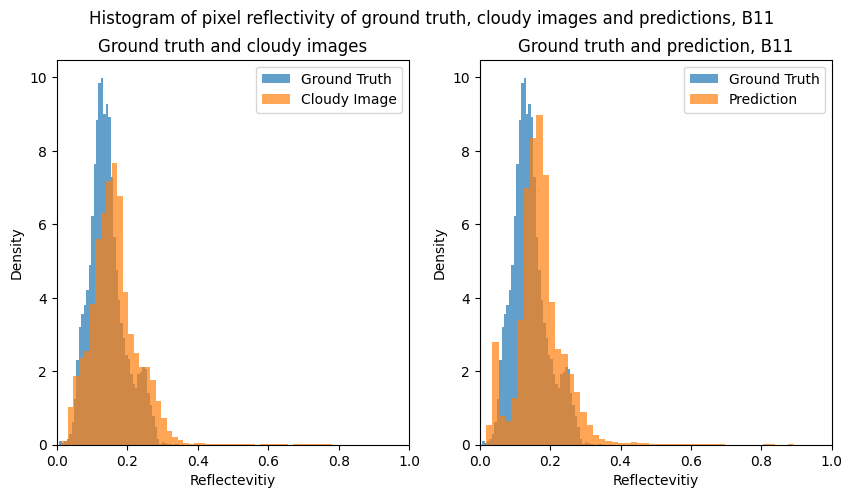

In [41]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]


axs[0].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

In [42]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r>0

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only cloudy pixels, B11')

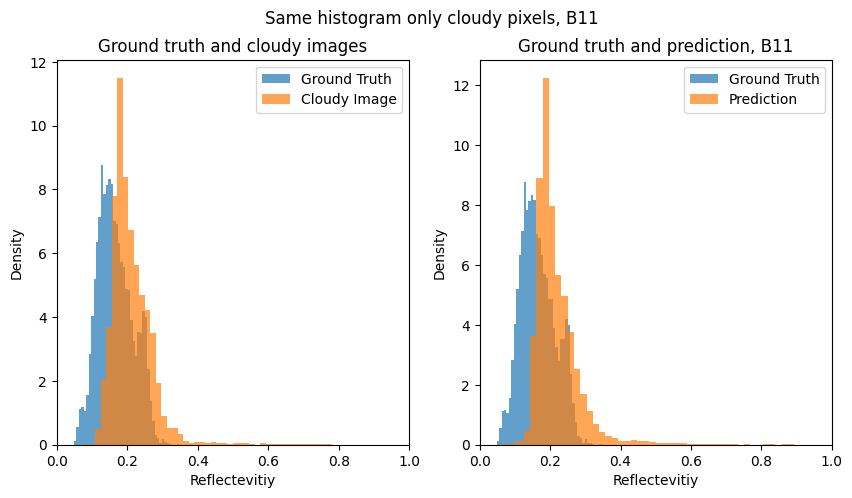

In [43]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only cloudy pixels, B11')

In [44]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==0

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only clear pixels, B11')

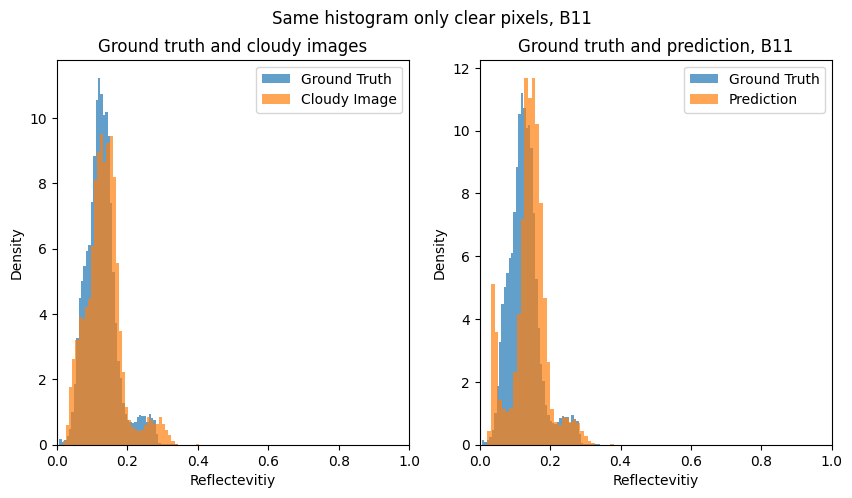

In [45]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only clear pixels, B11')

In [46]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==1

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

Text(0.5, 0.98, 'Same histogram only thin cloud pixels, B11')

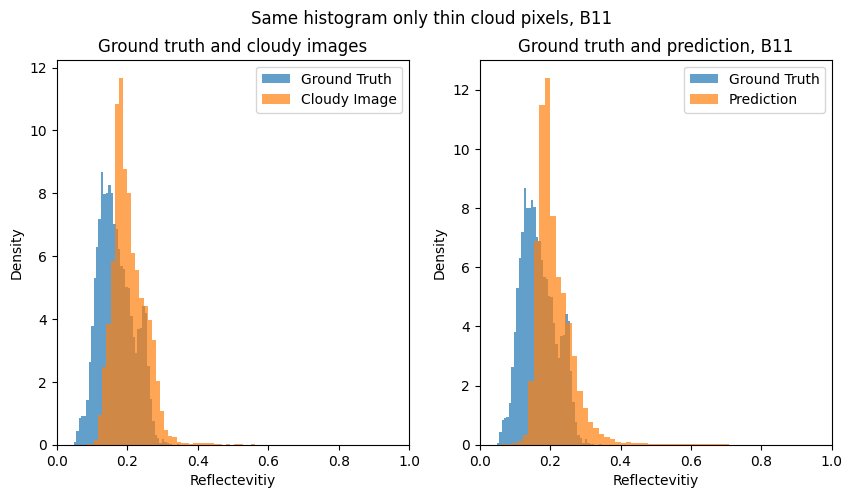

In [47]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thin cloud pixels, B11')

In [48]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))

p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)

        cloud_mask=im_cloud[:,:,-1]
        cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
        cloud_mask_r=cloud_mask_r==2

        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_r=im_pred_r[cloud_mask_r,:]
        im_clear_r=im_clear_r[cloud_mask_r,:]
        im_cloud_r=im_cloud_r[cloud_mask_r,:]


        clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
        pred_array_c=np.concatenate((pred_array_c,im_pred_r))
        cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

        p_c+=1

In [49]:
cots

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0.,

Text(0.5, 0.98, 'Same histogram only thick cloud pixels, B11')

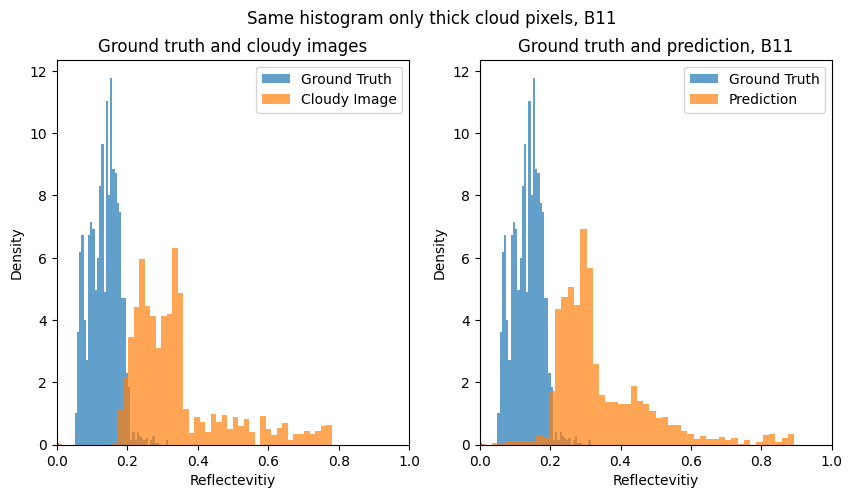

In [50]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thick cloud pixels, B11')

In [51]:
res=clear_array-pred_array

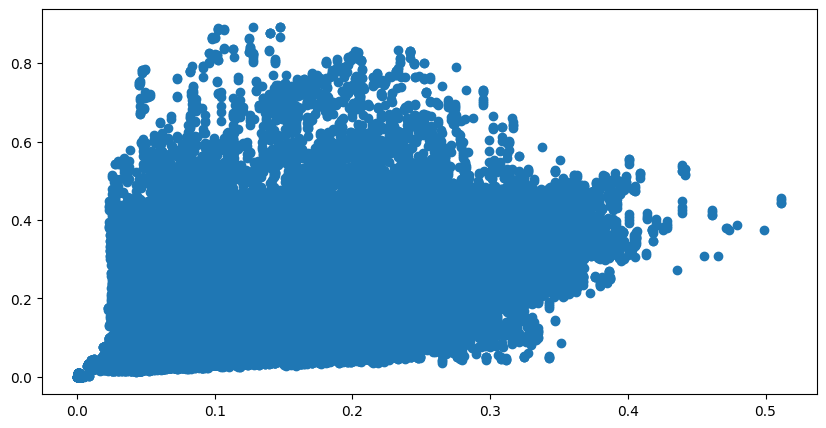

In [52]:
plt.scatter(clear_array,pred_array)

In [53]:
band=10
## Prediction v Ground Truth ##
y_true_11=clear_array[:,band]
pred_y_11=pred_array[:,band]
bins=np.linspace(0,0.6,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

clear_true=clear_array[cloud_mask_array==0,:]
thin_true=clear_array[cloud_mask_array==1,:]
semi_true=clear_array[cloud_mask_array==2,:]

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

clear_pred=pred_array[cloud_mask_array==0,:]
thin_pred=pred_array[cloud_mask_array==1,:]
semi_pred=pred_array[cloud_mask_array==2,:]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred


        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero


        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin


        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med



/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Ground truth over prediction, Real data')

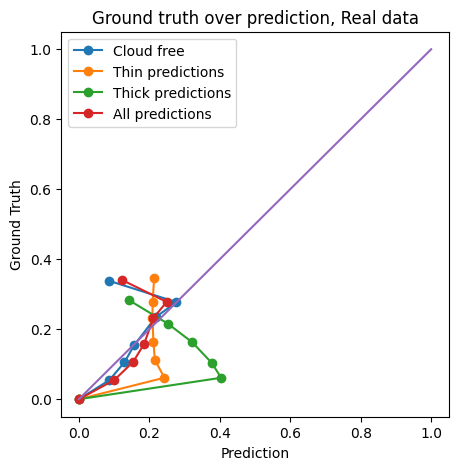

In [54]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Thick predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, Real data")

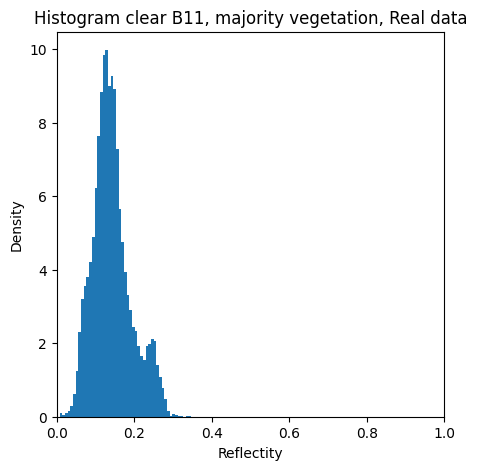

In [55]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(clear_array[:,10],bins=50,density=True)
plt.xlim([0,1])
plt.title('Histogram clear B11, majority vegetation, Real data')
plt.xlabel('Reflectity')
plt.ylabel('Density')
plt.show()

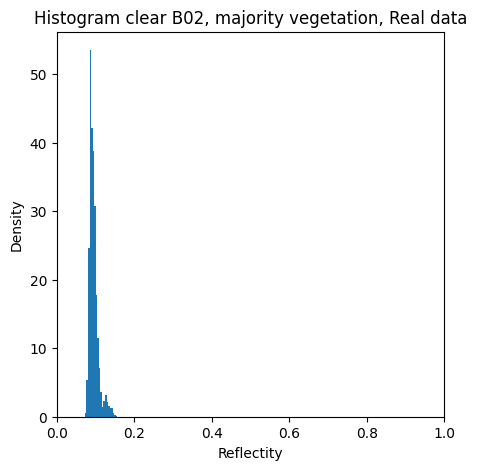

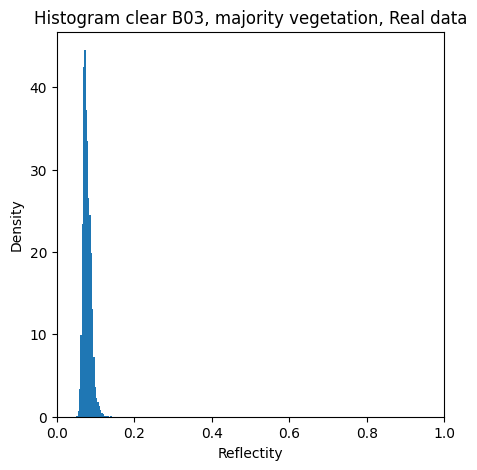

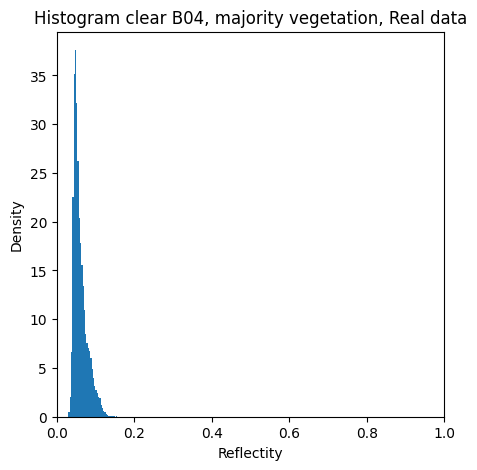

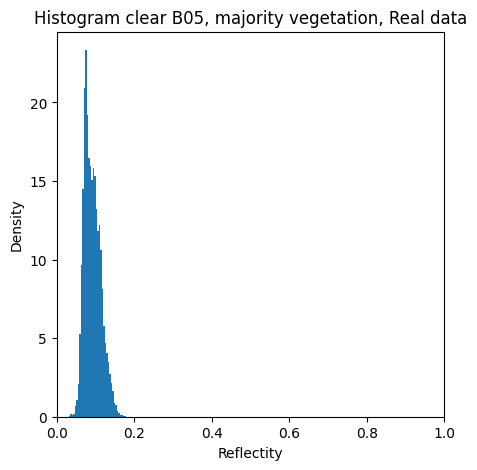

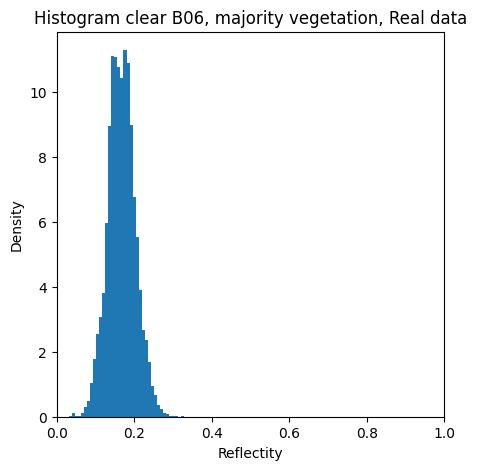

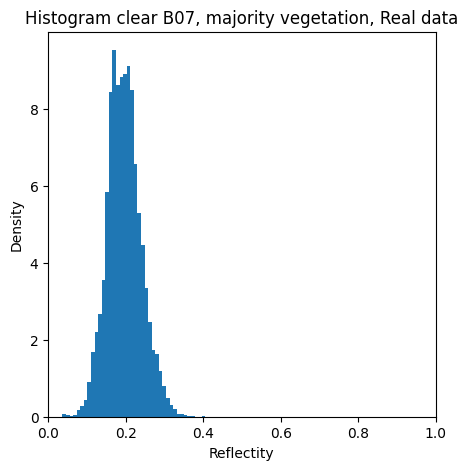

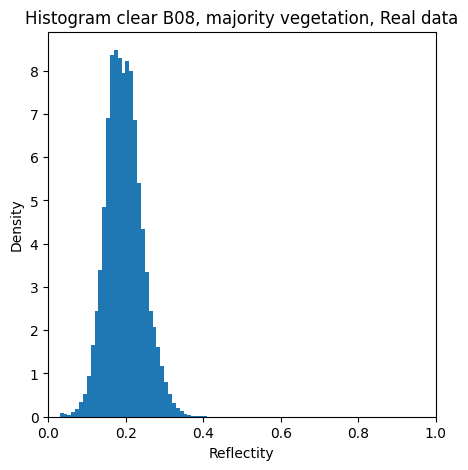

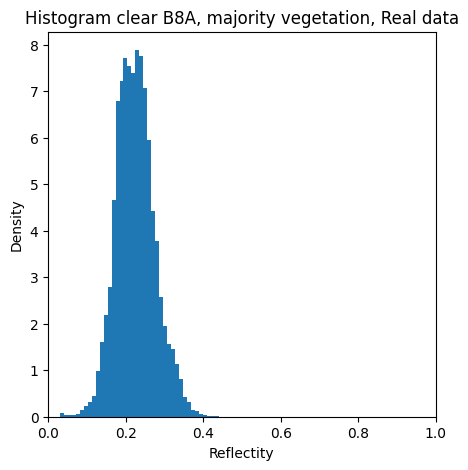

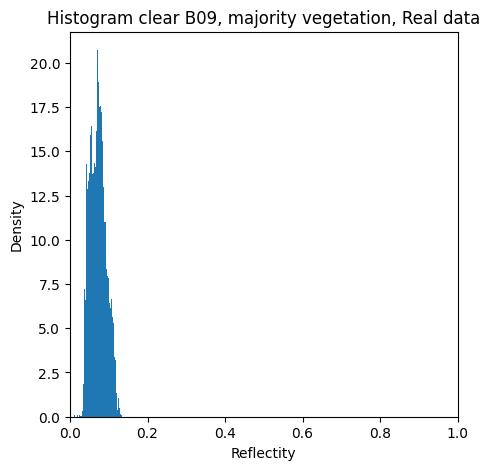

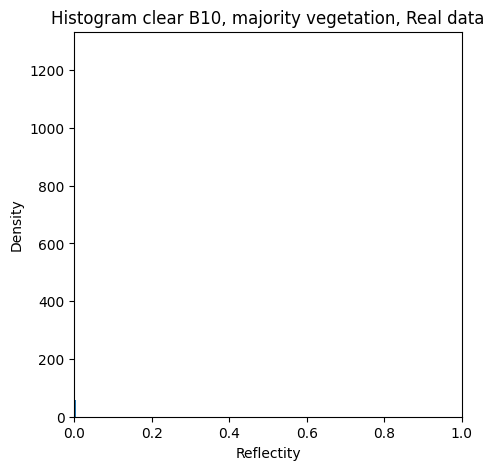

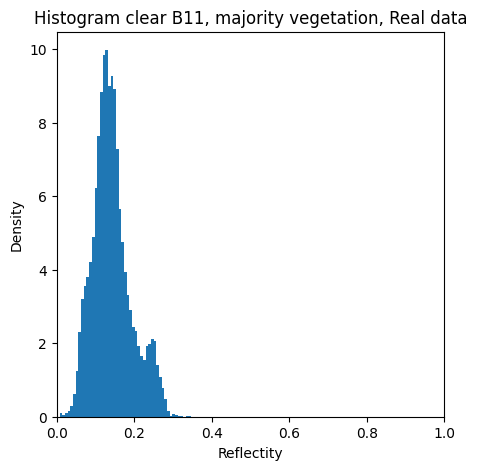

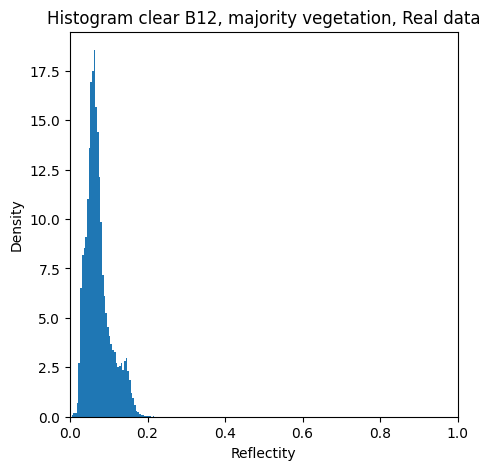

In [56]:
plt.rcParams["figure.figsize"] = [5, 5]
for band in range(0,12):

    plt.hist(clear_array[:,band],bins=50,density=True)
    plt.xlim([0,1])
    if band<7: 
        plt.title('Histogram clear B0'+str(band+2)+', majority vegetation, Real data')
    elif band==7:
        plt.title('Histogram clear B8A, majority vegetation, Real data')
    elif band==8:
        plt.title('Histogram clear B09, majority vegetation, Real data')
    else:
        plt.title('Histogram clear B'+str(band+1)+', majority vegetation, Real data')
    plt.xlabel('Reflectity')
    plt.ylabel('Density')
    plt.show()

## Specific image

In [57]:
pairs_all_ix

[[(6, 5), (11, 10)],
 [(19, 18)],
 [],
 [(13, 12)],
 [(9, 8), (30, 29), (39, 38)],
 [(5, 4), (7, 6), (8, 7)],
 [(15, 14)],
 [(16, 15), (25, 24)],
 [],
 [],
 [],
 [],
 [(8, 7)],
 [],
 [(15, 14), (20, 19), (90, 89), (123, 122)],
 [],
 [(6, 5)],
 [],
 [],
 [],
 [(17, 16)],
 [(16, 15), (25, 24)]]

In [58]:
which_pair=0 #5, 12

p_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=preds[j]

        if p_c==which_pair:
            break
        p_c+=1
    if p_c==which_pair:
        break


In [59]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

In [60]:
np.shape(im_clear[:,:,2])

(45, 45)

In [61]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

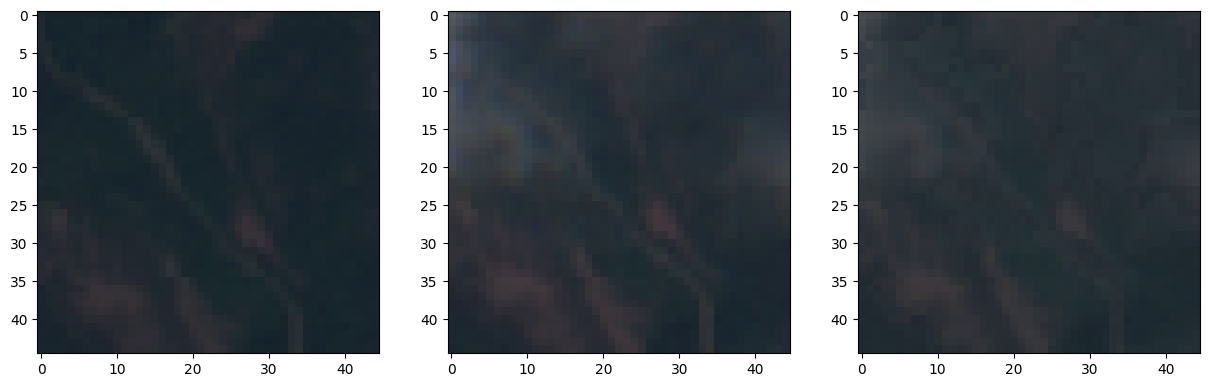

In [62]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
axs[2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

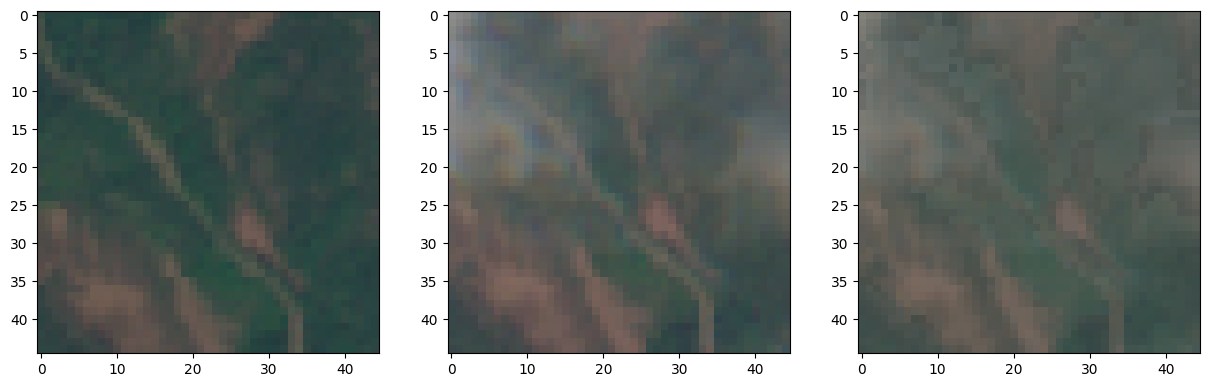

In [63]:
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])

## Test feeding the algorithm a clear image

In [85]:
pairs_all

[[('2023-06-07', '2023-05-26'), ('2023-07-10', '2023-07-02')],
 [('2023-09-13', '2023-09-08')],
 [('2023-05-21', '2023-05-13')],
 [('2023-08-29', '2023-07-23')],
 [('2020-08-16', '2020-08-02'),
  ('2022-06-25', '2022-06-22'),
  ('2022-09-08', '2022-09-03')],
 [('2022-09-21', '2022-09-19'),
  ('2022-10-23', '2022-10-04'),
  ('2023-05-22', '2022-10-23')],
 [('2023-04-17', '2023-04-12'),
  ('2023-05-27', '2023-05-22'),
  ('2023-06-03', '2023-06-01')],
 [('2023-05-06', '2023-04-26'),
  ('2023-06-07', '2023-06-02'),
  ('2023-08-16', '2023-08-01')],
 [],
 [('2023-05-07', '2023-05-06')],
 [('2023-04-16', '2023-04-11'),
  ('2023-05-19', '2023-05-11'),
  ('2023-09-06', '2023-08-22')],
 [],
 [('2023-06-11', '2023-05-29')],
 [('2023-04-16', '2023-04-03'),
  ('2023-04-21', '2023-04-18'),
  ('2023-05-11', '2023-05-06'),
  ('2023-06-07', '2023-05-31')],
 [('2018-08-27', '2018-08-25'),
  ('2018-09-06', '2018-09-04'),
  ('2019-05-17', '2019-05-14'),
  ('2020-05-26', '2020-05-23'),
  ('2020-08-24', '20

In [86]:
#pair=pairs_all[1][0]
#im=ims_all[1][0]

pair=pairs_all[0][0]
im=ims_all[0][0]



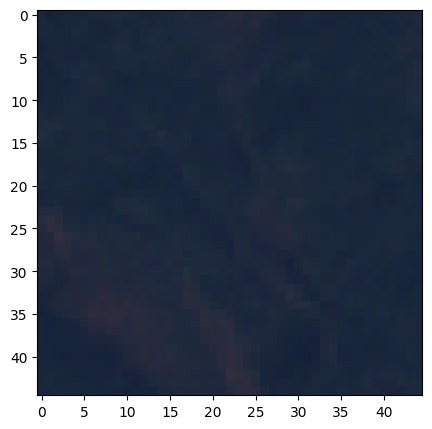

In [87]:
plt.imshow(np.flip(im[:,:,0:3],axis=2)*2)

In [88]:
## Reshape cloudy data
im_shape=np.shape(im)
im_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
for i in range(im_shape[2]):
    im_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])

im_pred_cot_t_r=im_r[:,-1]
#One hot encode cot
cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
cot_one_hot[im_pred_cot_t_r==0,0]=1
cot_one_hot[im_pred_cot_t_r==1,1]=1
cot_one_hot[im_pred_cot_t_r==2,2]=1

## append cot estimation to input data ##
im_r_c=np.zeros((np.shape(im_r)[0],np.shape(im_r)[1]+2))
im_r_c[:,0:13]=im_r[:,0:13]
im_r_c[:,13:16]=cot_one_hot

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_r_c)
    else:   
        pred=pred+model.predict(im_r_c)
pred=pred/len(models)

##Reshape back
im_shape_pred=(im_shape[0],im_shape[1],12)
im_pred=np.zeros(im_shape_pred)
im_unc=np.zeros(im_shape_pred)
for i in range(im_shape_pred[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

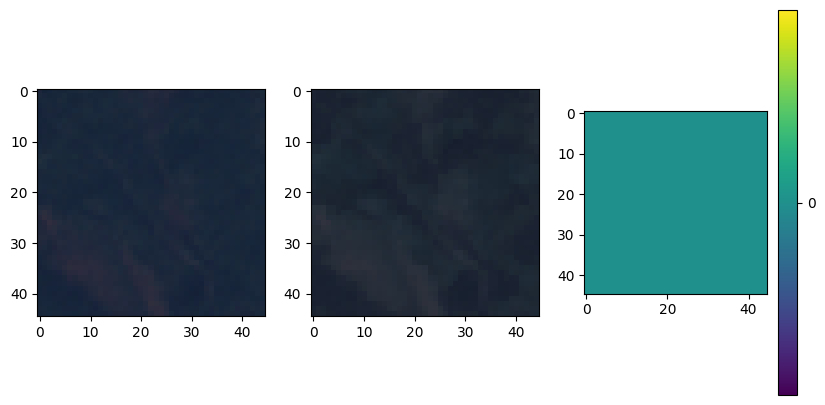

In [89]:
plt.rcParams["figure.figsize"] = [10, 5]
fig,axs=plt.subplots(nrows=1,ncols=3)
axs[0].imshow(np.flip(im[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)
i=axs[2].imshow(im[:,:,-1])
fig.colorbar(i,ax=axs[2],ticks=[0,1,2])

In [92]:

#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im[:,:,0:12])-(im[:,:,0:12])),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im[:,:,0:12]),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

NMSE_og_wo_10=np.concatenate((NMSE_og[0:9],NMSE_og[10:]),axis=0)
NMSE_pred_wo_10=np.concatenate((NMSE_pred[0:9],NMSE_pred[10:]),axis=0)

In [93]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')
print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(NMSE_pred_wo_10)))  

NMSE before correction, Band 2: 0.0
NMSE after correction, Band 2: 0.0002954206115164493
 
NMSE before correction, Band 3: 0.0
NMSE after correction, Band 3: 5.9456054211852944e-05
 
NMSE before correction, Band 4: 0.0
NMSE after correction, Band 4: 0.0002782224667032603
 
NMSE before correction, Band 5: 0.0
NMSE after correction, Band 5: 0.00041481883911295833
 
NMSE before correction, Band 6: 0.0
NMSE after correction, Band 6: 0.0014304136509435275
 
NMSE before correction, Band 7: 0.0
NMSE after correction, Band 7: 0.0015752054077750053
 
NMSE before correction, Band 8: 0.0
NMSE after correction, Band 8: 0.0027467762897775295
 
NMSE before correction, Band 8A: 0.0
NMSE after correction, Band 8A: 0.002555645979113582
 
NMSE before correction, Band 9: 0.0
NMSE after correction, Band 9: 0.0032948682958967505
 
NMSE before correction, Band 10: 0.0
NMSE after correction, Band 10: 0.04295835991033779
 
NMSE before correction, Band 11: 0.0
NMSE after correction, Band 11: 0.0168701605562456

## Spectrum plots

In [71]:
which_pair=16  #5, 12, ..., 14

p_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=preds[j]

        if p_c==which_pair:
            break
        p_c+=1
    if p_c==which_pair:
        break

In [72]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

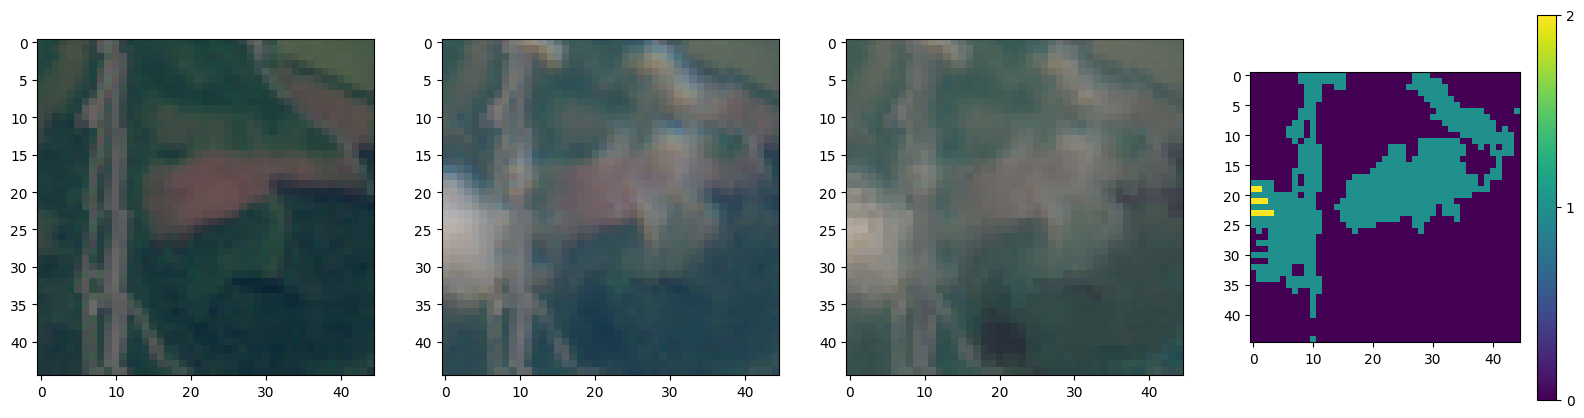

In [73]:
plt.rcParams["figure.figsize"] = [20, 5]
fig,axs=plt.subplots(ncols=4,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])
i=axs[3].imshow(im_cloud[:,:,-1])
fig.colorbar(i,ax=axs[3],ticks=[0,1,2])

In [74]:
pixel=(40,35)
pixel_clear=im_clear[pixel[0],pixel[1],:]
pixel_cloud=im_cloud[pixel[0],pixel[1],:]
pixel_pred=im_pred[pixel[0],pixel[1],:]

In [75]:
pixel_im_clear=np.ones((20,20,12))*pixel_clear[0:12]
pixel_im_cloud=np.ones((20,20,12))*pixel_cloud[0:12]
pixel_im_pred=np.ones((20,20,12))*pixel_pred[0:12]

In [76]:
## Get "True" RGB Clear##
b04Tp=sAdj(pixel_im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(pixel_im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(pixel_im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

pixel_im_clear_show=np.zeros(np.shape(pixel_im_clear[:,:,0:3]))
pixel_im_clear_show[:,:,0]=rgbLin[0]
pixel_im_clear_show[:,:,1]=rgbLin[1]
pixel_im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(pixel_im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(pixel_im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(pixel_im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

pixel_im_cloud_show=np.zeros(np.shape(pixel_im_cloud[:,:,0:3]))
pixel_im_cloud_show[:,:,0]=rgbLin[0]
pixel_im_cloud_show[:,:,1]=rgbLin[1]
pixel_im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(pixel_im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(pixel_im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(pixel_im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

pixel_im_pred_show=np.zeros(np.shape(pixel_im_pred[:,:,0:3]))
pixel_im_pred_show[:,:,0]=rgbLin[0]
pixel_im_pred_show[:,:,1]=rgbLin[1]
pixel_im_pred_show[:,:,2]=rgbLin[2]

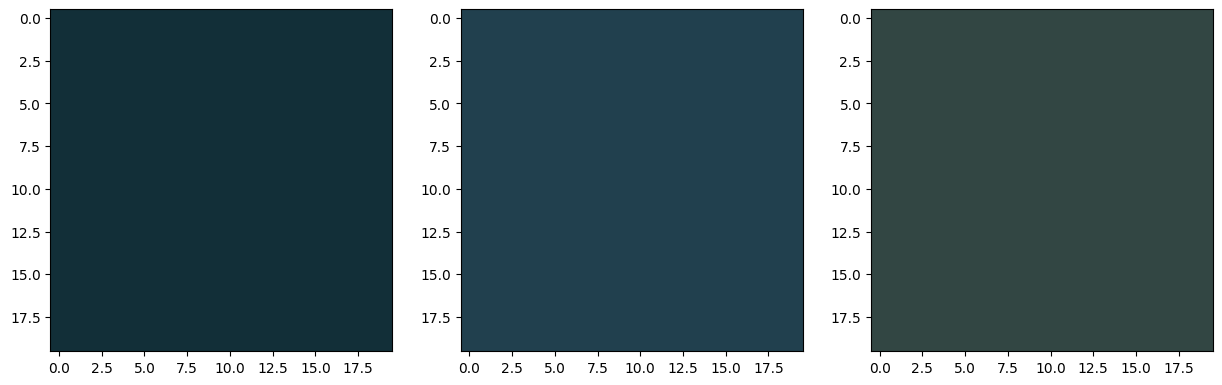

In [77]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(pixel_im_clear_show[:,:,0:3])
axs[1].imshow(pixel_im_cloud_show[:,:,0:3])
axs[2].imshow(pixel_im_pred_show[:,:,0:3])

In [78]:
channels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']

In [79]:
print("COT classification: "+str(pixel_cloud[-1]))

COT classification: 0.0


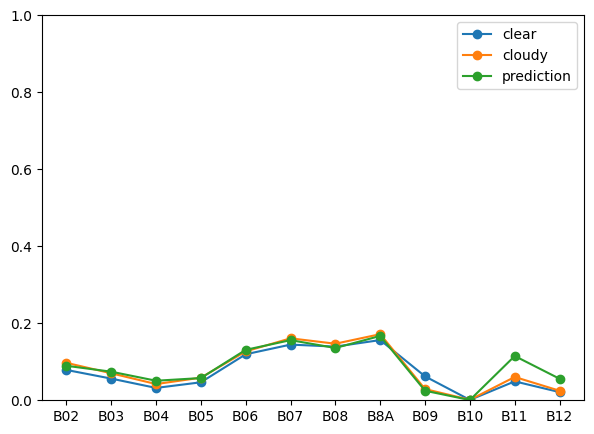

In [80]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(channels,pixel_clear[0:12],'-o')
plt.plot(channels,pixel_cloud[0:12],'-o')
plt.plot(channels,pixel_pred,'-o')
plt.ylim([0,1])
plt.legend(['clear','cloudy','prediction'])
plt.show()